## Baseline semi-supervised learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Split dataset into labeled and unlabeled subsets
num_labeled = 1000
num_unlabeled = len(dataset) - num_labeled
indices = np.arange(len(dataset))
np.random.shuffle(indices)

labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

labeled_set = Subset(dataset, labeled_indices)
unlabeled_set = Subset(dataset, unlabeled_indices)

labeled_loader = DataLoader(labeled_set, batch_size=64, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=64, shuffle=True)

# Define training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Define pseudo-labeling function
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.8):
    model.eval()
    pseudo_labels = []
    pseudo_data = []
    
    with torch.no_grad():
        for inputs, _ in unlabeled_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            confidence, preds = torch.max(probs, dim=1)
            mask = confidence > threshold
            pseudo_labels.extend(preds[mask].cpu().numpy())
            pseudo_data.extend(inputs[mask].cpu())

    return torch.stack(pseudo_data), torch.tensor(pseudo_labels)

# Initialize model, loss, and optimizer
model = SimpleCNN(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 1: Train model on labeled data
print("Training on labeled data...")
train_model(model, labeled_loader, criterion, optimizer, num_epochs=10)

# Step 2: Generate pseudo-labels
print("Generating pseudo-labels for unlabeled data...")
pseudo_data, pseudo_labels = generate_pseudo_labels(model, unlabeled_loader, threshold=0.8)

# Convert pseudo-data into DataLoader
pseudo_dataset = torch.utils.data.TensorDataset(pseudo_data, torch.tensor(pseudo_labels))
pseudo_loader = DataLoader(pseudo_dataset, batch_size=64, shuffle=True)

# Step 3: Retrain the model with both labeled and pseudo-labeled data
print("Retraining model with pseudo-labeled data...")
combined_loader = DataLoader(torch.utils.data.ConcatDataset([labeled_set, pseudo_dataset]), batch_size=64, shuffle=True)
train_model(model, combined_loader, criterion, optimizer, num_epochs=10)


100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Training on labeled data...
Epoch [1/10], Loss: 2.2282
Epoch [2/10], Loss: 2.0494
Epoch [3/10], Loss: 1.9153
Epoch [4/10], Loss: 1.8533
Epoch [5/10], Loss: 1.7518
Epoch [6/10], Loss: 1.6424
Epoch [7/10], Loss: 1.5817
Epoch [8/10], Loss: 1.4793
Epoch [9/10], Loss: 1.4398
Epoch [10/10], Loss: 1.3449
Generating pseudo-labels for unlabeled data...


/tmp/ipykernel_1449105/1651471208.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pseudo_dataset = torch.utils.data.TensorDataset(pseudo_data, torch.tensor(pseudo_labels))


Retraining model with pseudo-labeled data...


TypeError: expected Tensor as element 8 in argument 0, but got int

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
import numpy as np

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Split dataset into labeled and unlabeled subsets
num_labeled = 1000
indices = np.arange(len(dataset))
np.random.shuffle(indices)

labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

labeled_set = Subset(dataset, labeled_indices)
unlabeled_set = Subset(dataset, unlabeled_indices)

labeled_loader = DataLoader(labeled_set, batch_size=64, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=64, shuffle=True)

# Define training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Define pseudo-labeling function (Fixed)
def generate_pseudo_labels(model, unlabeled_loader, threshold=0.8):
    model.eval()
    pseudo_labeled_data = []
    
    with torch.no_grad():
        for inputs, _ in unlabeled_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            confidence, preds = torch.max(probs, dim=1)
            mask = confidence > threshold
            filtered_inputs = inputs[mask].cpu()
            filtered_preds = preds[mask].cpu()

            # Store as tuple (image, label) like a normal dataset
            pseudo_labeled_data.extend([(img, label) for img, label in zip(filtered_inputs, filtered_preds)])

    return pseudo_labeled_data

# Initialize model, loss, and optimizer
model = SimpleCNN(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 1: Train model on labeled data
print("Training on labeled data...")
train_model(model, labeled_loader, criterion, optimizer, num_epochs=10)

# Step 2: Generate pseudo-labels
print("Generating pseudo-labels for unlabeled data...")
pseudo_labeled_data = generate_pseudo_labels(model, unlabeled_loader, threshold=0.8)

# Convert pseudo-labeled data into a dataset
class PseudoDataset(torch.utils.data.Dataset):
    def __init__(self, pseudo_data):
        self.pseudo_data = pseudo_data  # List of tuples (image, label)
    
    def __len__(self):
        return len(self.pseudo_data)

    def __getitem__(self, idx):
        return self.pseudo_data[idx]

pseudo_dataset = PseudoDataset(pseudo_labeled_data)
pseudo_loader = DataLoader(pseudo_dataset, batch_size=64, shuffle=True)

# Step 3: Retrain the model with both labeled and pseudo-labeled data
print("Retraining model with pseudo-labeled data...")
combined_dataset = ConcatDataset([labeled_set, pseudo_dataset])  # Merging datasets properly
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

train_model(model, combined_loader, criterion, optimizer, num_epochs=10)


Files already downloaded and verified
Training on labeled data...
Epoch [1/10], Loss: 2.2266
Epoch [2/10], Loss: 2.0769
Epoch [3/10], Loss: 1.9448
Epoch [4/10], Loss: 1.8239
Epoch [5/10], Loss: 1.6984
Epoch [6/10], Loss: 1.5938
Epoch [7/10], Loss: 1.4672
Epoch [8/10], Loss: 1.3964
Epoch [9/10], Loss: 1.3231
Epoch [10/10], Loss: 1.2365
Generating pseudo-labels for unlabeled data...
Retraining model with pseudo-labeled data...


TypeError: expected Tensor as element 1 in argument 0, but got int

## Tutorial SSL-malware


In [ ]:
from distutils import core
import os

import datetime as dt
import logging
import numpy as np
import time
import torch
import xgboost as xgb

from collections import Counter, defaultdict
from dateutil.relativedelta import relativedelta
from pprint import pformat
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
import torch.nn.functional as F

# local imports
import data
from joblib import dump
import utils
from models import SimpleEncClassifier, MLPClassifier
from train import train_encoder, train_classifier
from similarity_score import get_high_similar_samples

def main():
    

    """
    Step (1): Prepare the training dataset. Load the feature vectors and labels.
    """
    data_dir = "/home/mhaque3/myDir/data/gen_apigraph_drebin"
    DATA = data_dir.split('/')[-1]
    TRAIN_START="2012-01"
    TRAIN_END="2012-12"
    TEST_START="2013-01"
    TEST_END="2018-12"
    logging.info(f'Dataset directory name {DATA}')

    logging.info(f'For API_GRAPH dataset start with the month 2012-01to2012-12_selected.')
    
    X_train, y_train, y_train_family = data.load_range_dataset_w_benign(data_dir, TRAIN_START, TRAIN_END)
    # all_train_family has 'benign'
    ben_len = X_train.shape[0] - y_train_family.shape[0]
    y_ben_family = np.full(ben_len, 'benign')
    all_train_family = np.concatenate((y_train_family, y_ben_family), axis=0)
    print(f"Number of y_train_family = {y_train_family}")
        
    train_families = set(all_train_family)
    print(f"Number of y_train_family = {y_train_family}")
    print(f"y_train = {y_train}")
    print(f"unique y_train = {np.unique(y_train)}")
    print(f'All train family = {all_train_family}')

    labeled_indices, unlabeled_indices = utils.get_labeled_unlabeled_indices(X_train, y_train, percentage_labeled=50)
    print(f"Number of labeled_indices = {len(labeled_indices)}")
    print(f"Number of unlabeled_indices = {len(unlabeled_indices)}")
    print(f"labeled_indices = {labeled_indices}")
    print(f"unlabeled_indices = {unlabeled_indices}")

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_train_binary_cat_tensor = torch.tensor([1 if item != 0 else 0 for item in y_train], dtype=torch.long)
    X_unlabeled_tensor = X_train_tensor[unlabeled_indices]
    X_unlabeled_tensor = torch.tensor(X_unlabeled_tensor, dtype=torch.float32)

    indicies, y_pseudo = get_high_similar_samples(X_train_tensor, y_train_binary_cat_tensor, y_train_tensor, X_unlabeled_tensor, sm_fn='cosine', num_samples=X_unlabeled_tensor.shape[1])
    print(f"Number of indicies = {len(indicies)}")
    
    # print(f"Calculating cosine similarity for the samples")
    # # cos_sim = F.cosine_similarity(X_train_tensor, X_train_tensor, dim=1)
    # # print(f"cosine similarity shape = {cos_sim.shape}")
    
    # A = X_train_tensor
    # B = X_unlabeled_tensor
    # dot_product = torch.mm(A, B.T)
    # # Compute L2 norm (magnitude) for each row
    # A_norm = torch.norm(A, p=2, dim=1, keepdim=True)  # Shape: (3,1)
    # B_norm = torch.norm(B, p=2, dim=1, keepdim=True)  # Shape: (5,1)

    # # Compute cosine similarity matrix (broadcasting norms)
    # cosine_similarity = dot_product / (A_norm * B_norm.T)

    # print("Cosine Similarity Matrix:\n", cosine_similarity)
    # print("Shape:", cosine_similarity.shape)
    """
    if args.data.startswith('tesseract') or \
        args.data.startswith('gen_tesseract') or \
        args.data.startswith('fam_tesseract') or \
        args.data.startswith('emberv2'):
        X_train, y_train, all_train_family = data.load_range_dataset_w_benign(args.data, args.train_start, args.train_end)
    else:
        logging.info(f'For API_GRAPH dataset start with the month 2012-01to2012-12_selected.')
        logging.info(f'For Androzoo dataset start with the month 2019-01to2019-12_selected.')
        
        X_train, y_train, y_train_family = data.load_range_dataset_w_benign(args.data, args.train_start, args.train_end)
        # all_train_family has 'benign'
        ben_len = X_train.shape[0] - y_train_family.shape[0]
        y_ben_family = np.full(ben_len, 'benign')
        all_train_family = np.concatenate((y_train_family, y_ben_family), axis=0)
            
    train_families = set(all_train_family)
    
    # count label distribution
    counted_labels = Counter(y_train)
    logging.info(f'Loaded X_train: {X_train.shape}, {y_train.shape}')
    logging.info(f'y_train labels: {np.unique(y_train)}')
    logging.info(f'y_train: {Counter(y_train)}')

    # the index mapping for the first training set
    new_y_mapping = {}
    for _, label in enumerate(np.unique(y_train)):
        new_y_mapping[label] = label
    
    """
    # Step (2): Variable names and file names.
    """
    # some commonly used variables.
    if args.train_start != args.train_end:
        train_dataset_name = f'{args.train_start}to{args.train_end}'
    else:
        train_dataset_name = f'{args.train_start}'

    SAVED_MODEL_FOLDER = 'models/'
    # only based on malicious training samples
    NUM_FEATURES = X_train.shape[1]
    NUM_CLASSES = len(np.unique(y_train))

    logging.info(f'Number of features: {NUM_FEATURES}; Number of classes: {NUM_CLASSES}')

    # convert y_train to y_train_binary
    y_train_binary = np.array([1 if item != 0 else 0 for item in y_train])
    BIN_NUM_CLASSES = 2
    """

In [2]:
if __name__ == "__main__":
    main()

Number of y_train_family = ['droidkungfu' 'steek' 'fakedoc' ... 'exploit' 'adware' 'opfake']
Number of y_train_family = ['droidkungfu' 'steek' 'fakedoc' ... 'exploit' 'adware' 'opfake']
y_train = [1. 2. 3. ... 0. 0. 0.]
unique y_train = [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105.]
All train family = ['droidkungfu' 'steek' 'fakedoc' ... 'benign' 'benign' 'benign']
Number of labeled_indices = 15232
Number of unlabeled_indices = 15301
labeled_indices = [21615, 16925, 19843, 11870, 10998, 26991, 7610, 107

/tmp/ipykernel_223244/4223881182.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_unlabeled_tensor = torch.tensor(X_unlabeled_tensor, dtype=torch.float32)


Number of indicies = 50


### Ploting from result_ours

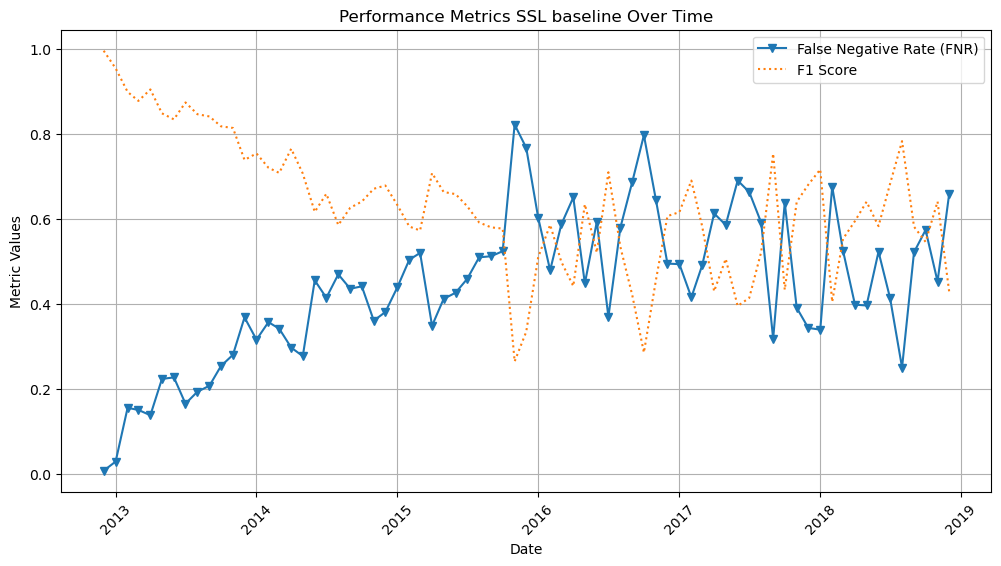

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "/home/mhaque3/myDir/SSL-malware/results_all/results_chen_wo_AL/gen_apigraph_cnt200_088_warm_lr0.003_sgd_step_0.95_e250_adam_wlr0.00015_we100_test_2013-01_2018-12_cnt200.csv"  # Change this to your actual file path
df = pd.read_csv(file_path, sep="\t")

# Convert the 'date' column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

# Set the date as the index
df.set_index("date", inplace=True)

# Plot the different metrics over time
plt.figure(figsize=(12, 6))

# Plot True Positive Rate (TPR) and True Negative Rate (TNR)
# plt.plot(df.index, df["TPR"], label="True Positive Rate (TPR)", marker="o")
# plt.plot(df.index, df["TNR"], label="True Negative Rate (TNR)", marker="s")

# # Plot False Positive Rate (FPR) and False Negative Rate (FNR)
# plt.plot(df.index, df["FPR"], label="False Positive Rate (FPR)", marker="^")
plt.plot(df.index, df["FNR"], label="False Negative Rate (FNR)", marker="v")

# Plot Accuracy (ACC), Precision (PREC), and F1 Score (F1)
# plt.plot(df.index, df["ACC"], label="Accuracy (ACC)", linestyle="--")
# plt.plot(df.index, df["PREC"], label="Precision (PREC)", linestyle="-.")
plt.plot(df.index, df["F1"], label="F1 Score", linestyle=":")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Metric Values")
plt.title("Performance Metrics SSL baseline Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


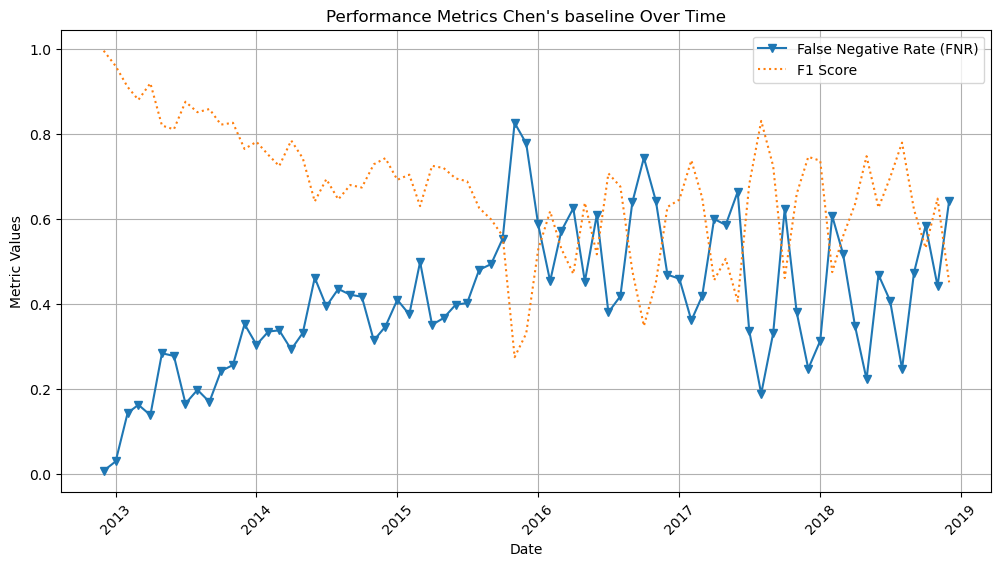

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "/home/mhaque3/myDir/SSL-malware/results_all/results_ours_SSL_baseline_without_AL/gen_apigraph_cnt200_03.05-15.17.06.csv"  # Change this to your actual file path
df = pd.read_csv(file_path, sep="\t")

# Convert the 'date' column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

# Set the date as the index
df.set_index("date", inplace=True)

# Plot the different metrics over time
plt.figure(figsize=(12, 6))

# Plot True Positive Rate (TPR) and True Negative Rate (TNR)
# plt.plot(df.index, df["TPR"], label="True Positive Rate (TPR)", marker="o")
# plt.plot(df.index, df["TNR"], label="True Negative Rate (TNR)", marker="s")

# # Plot False Positive Rate (FPR) and False Negative Rate (FNR)
# plt.plot(df.index, df["FPR"], label="False Positive Rate (FPR)", marker="^")
plt.plot(df.index, df["FNR"], label="False Negative Rate (FNR)", marker="v")

# Plot Accuracy (ACC), Precision (PREC), and F1 Score (F1)
# plt.plot(df.index, df["ACC"], label="Accuracy (ACC)", linestyle="--")
# plt.plot(df.index, df["PREC"], label="Precision (PREC)", linestyle="-.")
plt.plot(df.index, df["F1"], label="F1 Score", linestyle=":")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Metric Values")
plt.title("Performance Metrics Chen's baseline Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


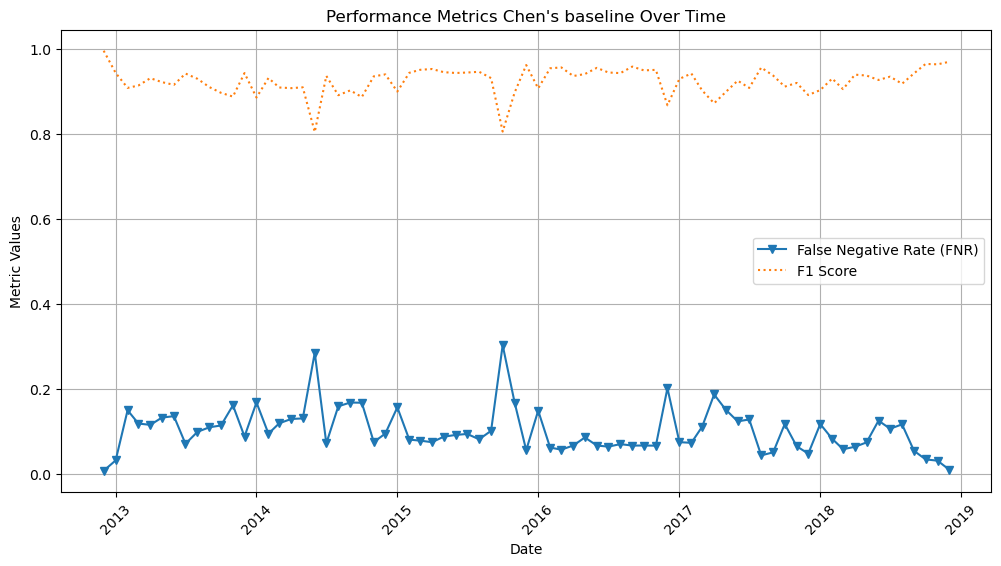

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "/home/mhaque3/myDir/SSL-malware/results_all/results_ours_wagner/gen_apigraph_cnt200_088_warm_lr0.003_sgd_step_0.95_e250_adam_wlr0.00015_we100_test_2013-01_2018-12_cnt200.csv"  # Change this to your actual file path
df = pd.read_csv(file_path, sep="\t")

# Convert the 'date' column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

# Set the date as the index
df.set_index("date", inplace=True)

# Plot the different metrics over time
plt.figure(figsize=(12, 6))

# Plot True Positive Rate (TPR) and True Negative Rate (TNR)
# plt.plot(df.index, df["TPR"], label="True Positive Rate (TPR)", marker="o")
# plt.plot(df.index, df["TNR"], label="True Negative Rate (TNR)", marker="s")

# # Plot False Positive Rate (FPR) and False Negative Rate (FNR)
# plt.plot(df.index, df["FPR"], label="False Positive Rate (FPR)", marker="^")
plt.plot(df.index, df["FNR"], label="False Negative Rate (FNR)", marker="v")

# Plot Accuracy (ACC), Precision (PREC), and F1 Score (F1)
# plt.plot(df.index, df["ACC"], label="Accuracy (ACC)", linestyle="--")
# plt.plot(df.index, df["PREC"], label="Precision (PREC)", linestyle="-.")
plt.plot(df.index, df["F1"], label="F1 Score", linestyle=":")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Metric Values")
plt.title("Performance Metrics Chen's baseline Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()



# Semi-Supervised Learning(Self-Training) with 1% Labeled Data
https://medium.com/@a.r.amouzad.m/semi-supervised-learning-self-training-with-1-labeled-data-aeda3bfb108f

## Step 1: Loading Dataset

In [10]:
def prepare_data(labeled_ratio, batch_size):
    """
    Prepares the MNIST dataset for semi-supervised learning by splitting the training data 
    into labeled and unlabeled subsets based on the specified labeled_ratio.

    Args:
        labeled_ratio (float): Proportion of the dataset to be used for labeled data (0 < labeled_ratio < 1).
        batch_size (int): Batch size to be used for the DataLoader.

    Returns:
        tuple: A tuple containing:
            - labeled_loader (DataLoader): DataLoader for the labeled dataset.
            - unlabeled_loader (DataLoader): DataLoader for the unlabeled dataset.
            - test_loader (DataLoader): DataLoader for the test dataset.
    
    Prints:
        - Class distribution in the labeled dataset.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize for MNIST
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    # Calculate samples per class for labeled data
    total_samples = len(train_dataset)
    num_classes = 10
    samples_per_class = int((labeled_ratio * total_samples) / num_classes)

    # Create dictionaries to store indices for each class
    class_indices = {i: [] for i in range(num_classes)}
    
    # Group indices by class
    for idx, (_, label) in enumerate(train_dataset):
        class_indices[label].append(idx)

    # Randomly select equal number of samples from each class for labeled data
    labeled_indices = []
    unlabeled_indices = []
    
    for class_label in range(num_classes):
        # Shuffle indices for current class
        current_class_indices = class_indices[class_label]
        np.random.shuffle(current_class_indices)
        
        # Select samples for labeled set
        labeled_indices.extend(current_class_indices[:samples_per_class])
        # Remaining samples go to unlabeled set
        unlabeled_indices.extend(current_class_indices[samples_per_class:])

    # Shuffle both sets of indices
    np.random.shuffle(labeled_indices)
    np.random.shuffle(unlabeled_indices)

    # Create subsets
    labeled_dataset = Subset(train_dataset, labeled_indices)
    unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

    # Verify class distribution in labeled set
    labeled_distribution = {i: 0 for i in range(num_classes)}
    for idx in labeled_indices:
        _, label = train_dataset[idx]
        labeled_distribution[label] += 1
    
    print("\nLabeled data class distribution:")
    for class_idx, count in labeled_distribution.items():
        print(f"Class {class_idx}: {count} samples ({count/len(labeled_indices)*100:.2f}%)")

    # Create DataLoaders
    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return labeled_loader, unlabeled_loader, test_loader

## Step 2: Creating Simple CNN Model

In [11]:
def create_model():
    """
    Creates and returns a custom Convolutional Neural Network (CNN) model for image classification.

    The model consists of three convolutional layers, each followed by batch normalization, ReLU activation, 
    max pooling, and dropout. The output of the convolutional layers is passed through two fully connected layers
    to produce the final classification output.

    The architecture is as follows:
        - 3 Convolutional layers with increasing filter sizes (8, 16, 32).
        - Max pooling and dropout after each convolutional layer.
        - Flatten the output from the convolutional layers before passing to the fully connected layers.
        - Fully connected layers: one hidden layer with 128 units and dropout, followed by an output layer with 10 units (for 10 classes).
    
    Returns:
        nn.Module: A PyTorch model instance of the CustomCNN class.

    """
    def single_conv_layer(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

    class CustomCNN(nn.Module):
        def __init__(self):
            super(CustomCNN, self).__init__()
            self.conv_layers = nn.Sequential(
                single_conv_layer(1, 8),
                single_conv_layer(8, 16),
                single_conv_layer(16, 32)
            )

            self.fc_layers = nn.Sequential(
                nn.Linear(32 * 3 * 3, 128),  # Adjust based on the input image size.
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(128, 10)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers.
            x = self.fc_layers(x)
            return x
            
    return CustomCNN()

## Step 3: Augmentation

In [12]:
class AugmentationTransforms:
    """
    A class to define different image transformations for data augmentation.

    This class provides transformations for:
        - Strong augmentation: Used for unlabeled data, with larger random affine transformations (translation and scale).
        - Weak augmentation: Used for labeled data, with smaller random affine transformations (translation and scale).
        - Test transformation: Used for test data, with no augmentation other than converting to a tensor.

    Attributes:
        strong_transform (transforms.Compose): A pipeline of transformations applying stronger augmentation to images.
        weak_transform (transforms.Compose): A pipeline of transformations applying weaker augmentation to images.
        test_transform (transforms.Compose): A pipeline for test data, which only converts images to tensor format.

    Methods:
        __init__(self): Initializes the augmentation transforms with predefined strong, weak, and test transformations.

    """
    def __init__(self):
        self.strong_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
        ])

        self.weak_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(degrees=3, translate=(0.05, 0.05), scale=(0.95, 1.05)),
            transforms.ToTensor(),
        ])

## Step 4: Custom Loss Function Using Active Learning

In [13]:
class CustomActiveLearningLoss:
    """
    Custom loss function for active learning that combines supervised loss and pseudo-label loss.
    The loss is weighted based on prediction uncertainty for labeled samples and confidence for pseudo-labeled samples.
    
    Attributes:
        pseudo_weight (float): Weight for the pseudo-label loss.
        temperature (float): Temperature parameter for softening predictions.
        uncertainty_weight (float): Weight for uncertainty-based loss adjustment.
        criterion (torch.nn.CrossEntropyLoss): Cross entropy loss used for computing both supervised and pseudo-label losses.
    """
    
    def __init__(self, pseudo_weight=0.5, temperature=1.0, uncertainty_weight=1.0):
        """
        Initializes the CustomActiveLearningLoss object.
        
        Args:
            pseudo_weight (float): Weight for the pseudo-label loss (default is 0.5).
            temperature (float): Temperature parameter for scaling softmax output (default is 1.0).
            uncertainty_weight (float): Weight to adjust loss based on uncertainty (default is 1.0).
        """
        self.pseudo_weight = pseudo_weight
        self.temperature = temperature
        self.uncertainty_weight = uncertainty_weight
        self.criterion = nn.CrossEntropyLoss(reduction='none')
        
    def calculate_uncertainty(self, outputs):
        """
        Calculates uncertainty scores based on prediction entropy.
        
        Entropy measures the uncertainty of a prediction, with higher values indicating greater uncertainty.
        
        Args:
            outputs (torch.Tensor): Model outputs (logits) for the input data.
        
        Returns:
            torch.Tensor: Uncertainty values computed as entropy for each sample in the batch.
        """
        probs = F.softmax(outputs / self.temperature, dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
        return entropy
    
    def get_confidence_weights(self, outputs):
        """
        Calculates confidence-based weights for pseudo-labels based on prediction confidence.
        
        Confidence is computed as the highest probability predicted for each sample.
        
        Args:
            outputs (torch.Tensor): Model outputs (logits) for the input data.
        
        Returns:
            torch.Tensor: Confidence weights for each sample based on the predicted probabilities.
        """
        probs = F.softmax(outputs / self.temperature, dim=-1)
        confidence, _ = torch.max(probs, dim=-1)
        return confidence
    
    def __call__(self, labeled_outputs, labels, pseudo_outputs=None, pseudo_labels=None):
        """
        Computes the total loss by combining the supervised and pseudo-label losses, adjusted by uncertainty and confidence weights.
        
        Args:
            labeled_outputs (torch.Tensor): Model outputs (logits) for labeled data.
            labels (torch.Tensor): Ground truth labels for labeled data.
            pseudo_outputs (torch.Tensor, optional): Model outputs (logits) for pseudo-labeled data.
            pseudo_labels (torch.Tensor, optional): Pseudo-labels for the pseudo-labeled data.
        
        Returns:
            torch.Tensor: The total loss for the active learning task, combining supervised and pseudo-label losses.
        """
        loss = 0
        
        # Supervised loss with uncertainty weighting
        if labeled_outputs is not None and labels is not None:
            supervised_loss = self.criterion(labeled_outputs / self.temperature, labels)
            
            # Add uncertainty weighting for labeled samples
            uncertainty = self.calculate_uncertainty(labeled_outputs)
            normalized_uncertainty = uncertainty / (uncertainty.max() + 1e-10)
            weighted_supervised_loss = supervised_loss * (1 + self.uncertainty_weight * normalized_uncertainty)
            loss += weighted_supervised_loss.mean()
        
        # Pseudo-label loss with confidence weighting
        if pseudo_outputs is not None and pseudo_labels is not None:
            pseudo_loss = self.criterion(pseudo_outputs / self.temperature, pseudo_labels)
            
            # Weight pseudo-labels by prediction confidence
            confidence_weights = self.get_confidence_weights(pseudo_outputs)
            weighted_pseudo_loss = pseudo_loss * confidence_weights
            
            # Add uncertainty weighting for pseudo-labeled samples
            uncertainty = self.calculate_uncertainty(pseudo_outputs)
            normalized_uncertainty = uncertainty / (uncertainty.max() + 1e-10)
            weighted_pseudo_loss = weighted_pseudo_loss * (1 + self.uncertainty_weight * normalized_uncertainty)
            
            loss += self.pseudo_weight * weighted_pseudo_loss.mean()
        
        return loss

## Step 5: Training-Testing

### 1. self_train

In [14]:
def self_train(self, labeled_loader, unlabeled_loader, test_loader, num_epochs=100):
    total_data = len(labeled_loader.dataset) + len(unlabeled_loader.dataset)
    
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        
        # Training phase
        loss = self.train_on_labeled(labeled_loader, epoch)
        labeled_accuracy = self.calculate_accuracy(labeled_loader)
        
        # Update pseudo-labels periodically
        if epoch % 25 == 0:
            pseudo_data, pseudo_targets, pseudo_indices = self.generate_pseudo_labels(unlabeled_loader, epoch)
            
            # Update pseudo labels with uncertainty consideration
            self.pseudo_loader = self.update_pseudo_labels(pseudo_data, pseudo_targets)
            
            # Remove pseudo-labeled samples from unlabeled dataset
            unlabeled_loader = self.remove_pseudo_labeled_from_unlabeled(unlabeled_loader, pseudo_indices)
            
            # Evaluate model performance
            test_accuracy = self.calculate_accuracy(test_loader)
            
            if test_accuracy > self.best_accuracy:
                self.best_accuracy = test_accuracy
                self.best_model_state = self.model.state_dict().copy()
                self.save_model()
            
            # Calculate and display metrics
            labeled_ratio = (len(labeled_loader.dataset) + 
                           (len(self.pseudo_loader.dataset) if self.pseudo_loader is not None else 0)) / total_data
            
            tqdm.write(
                f"Epoch {epoch} Summary: "
                f"Loss = {loss:.6f}, "
                f"Pseudo-labels added = {len(pseudo_data)}, "
                f"Labeled data ratio = {labeled_ratio:.2%}, "
                f"Labeled Accuracy = {labeled_accuracy:.2f}%, "
                f"Test Accuracy = {test_accuracy:.2f}%, "
                f"Best Test Accuracy = {self.best_accuracy:.2f}%"
            )
        else:
            tqdm.write(f"Epoch {epoch} Summary: "
                      f"Loss = {loss:.6f}, "
                      f"Labeled Accuracy = {labeled_accuracy:.2f}%")
    
    # Final evaluation
    print("\nTraining completed. Loading best model for final evaluation...")
    self.load_best_model()
    final_accuracy, class_accuracies = self.evaluate_model(test_loader)
    
    return final_accuracy, class_accuracies

### 2. train_on_labeled

In [15]:
def train_on_labeled(self, labeled_loader, epoch):
    self.model.train()
    total_loss = 0
    progress_bar = tqdm(labeled_loader, desc=f"[Epoch {epoch}] Training", leave=False)

    for data, labels in progress_bar:
        data, labels = data.to(self.device), labels.to(self.device)
        
        # Augment and get model outputs
        augmented_data = self.augment_data(data, is_labeled=True)
        outputs = self.model(augmented_data)

        self.optimizer.zero_grad()
        
        # Calculate loss with uncertainty weighting
        labeled_loss = self.custom_loss(outputs, labels)

        if self.pseudo_loader is not None:
            pseudo_loss = 0
            pseudo_count = 0

            for pseudo_data, pseudo_labels in self.pseudo_loader:
                pseudo_data, pseudo_labels = pseudo_data.to(self.device), pseudo_labels.to(self.device)
                
                # Augment and get model outputs for pseudo-labeled data
                augmented_pseudo = self.augment_data(pseudo_data, is_labeled=False)
                pseudo_outputs = self.model(augmented_pseudo)

                # Calculate pseudo loss with uncertainty weighting
                batch_pseudo_loss = self.custom_loss(None, None, pseudo_outputs, pseudo_labels)
                
                pseudo_loss += batch_pseudo_loss
                pseudo_count += 1

            if pseudo_count > 0:
                labeled_loss += pseudo_loss / pseudo_count

        labeled_loss.backward()
        self.optimizer.step()

        total_loss += labeled_loss.item()
        progress_bar.set_postfix({"Batch Loss": labeled_loss.item()})

    return total_loss / len(progress_bar)

### 3. generate_pseudo_labels

In [16]:
def generate_pseudo_labels(self, unlabeled_loader, epoch):
    self.model.eval()
    pseudo_data = []
    pseudo_targets = []
    selected_indices = []

    with torch.no_grad():
        progress_bar = tqdm(unlabeled_loader, desc=f"Generating Pseudo Labels (Epoch {epoch})", leave=False)

        for batch_idx, (inputs, _) in enumerate(progress_bar):
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            probabilities = torch.softmax(outputs / self.custom_loss.temperature, dim=1)
            confidence, predicted = torch.max(probabilities, dim=1)
            
            # Combine confidence threshold with uncertainty-based selection
            high_confidence_mask = confidence > self.confidence_threshold
            
            # Select samples based on both confidence
            selected_data = inputs[high_confidence_mask]
            selected_labels = predicted[high_confidence_mask]
            
            batch_indices = torch.arange(batch_idx * self.batch_size, 
                                       batch_idx * self.batch_size + len(inputs))
            selected_batch_indices = batch_indices[high_confidence_mask.cpu()]
            
            if selected_data.size(0) > 0:
                pseudo_data.append(selected_data)
                pseudo_targets.append(selected_labels)
                selected_indices.extend(selected_batch_indices.tolist())

    if pseudo_data:
        pseudo_data = torch.cat(pseudo_data, dim=0)
        pseudo_targets = torch.cat(pseudo_targets, dim=0)
        
    selected_indices = torch.tensor(selected_indices, dtype=torch.int)
    pseudo_indices = torch.tensor(unlabeled_loader.dataset.indices)[selected_indices]
    
    return pseudo_data, pseudo_targets, pseudo_indices

### 4. update_pseudo_labels

In [17]:
def update_pseudo_labels(self, new_pseudo_data, new_pseudo_targets):
    if len(new_pseudo_data) == 0:
        return

    if self.pseudo_data is not None:
        # Combine existing and new pseudo labels
        self.pseudo_data = torch.cat([self.pseudo_data, new_pseudo_data], dim=0)
        self.pseudo_targets = torch.cat([self.pseudo_targets, new_pseudo_targets], dim=0)
    else:
        self.pseudo_data = new_pseudo_data
        self.pseudo_targets = new_pseudo_targets

    # Create a new DataLoader for pseudo-labeled data
    return DataLoader(TensorDataset(self.pseudo_data, self.pseudo_targets),
                                    batch_size=self.batch_size,
                                    shuffle=True)

### 5. remove_pseudo_labeled_from_unlabeled

In [18]:
def remove_pseudo_labeled_from_unlabeled(self, unlabeled_loader, pseudo_indices):
    # Create a new set of indices excluding pseudo-labeled samples
    remaining_indices = list(set(unlabeled_loader.dataset.indices) - set(pseudo_indices.numpy()))

    # Reindex to have consecutive indices starting from 0
    remaining_dataset = Subset(unlabeled_loader.dataset, remaining_indices)
    remaining_dataset.indices = list(range(len(remaining_dataset)))

    # Create a DataLoader for the remaining dataset
    remaining_dataloader = DataLoader(remaining_dataset, batch_size=self.batch_size, shuffle=True)
    return remaining_dataloader

## Traning the Semi-supervised learning

In [19]:
class SelfTraining:
    """
    A class implementing self-training for semi-supervised learning.

    This class implements a self-training algorithm that utilizes both labeled and unlabeled data
    to improve model performance. It includes features like pseudo-labeling, data augmentation,
    and uncertainty-based sample selection.

    Args:
        model: The neural network model to be trained
        optimizer: The optimizer to be used for training
        confidence_threshold (float): Threshold for pseudo-label selection (default: 0.9)
        batch_size (int): Size of mini-batches (default: 256)
        device (str): Device to run the model on ('cpu' or 'cuda') (default: 'cpu')
        pseudo_weight (float): Weight for pseudo-labeled loss (default: 0.3)
        temperature (float): Temperature parameter for softmax (default: 1.0)
        uncertainty_weight (float): Weight for uncertainty in loss calculation (default: 1.0)
        model_save_path (str): Path to save the best model (default: 'best_model.pth')
    """

    def __init__(self, model, optimizer, confidence_threshold=0.9, batch_size=256,
                 device="cpu", pseudo_weight=0.3, temperature=1.0, uncertainty_weight=1.0,
                 model_save_path='best_model.pth'):
        self.model = model
        self.custom_loss = CustomActiveLearningLoss(
            pseudo_weight=pseudo_weight,
            temperature=temperature,
            uncertainty_weight=uncertainty_weight
        )
        self.optimizer = optimizer
        self.confidence_threshold = confidence_threshold
        self.batch_size = batch_size
        self.device = device
        self.best_model_state = None
        self.best_accuracy = 0
        self.model_save_path = model_save_path
        self.augmenter = AugmentationTransforms()
        self.pseudo_loader = None
        self.pseudo_data = None
        self.pseudo_targets = None

    def save_model(self):
        """
        Save the current model state to disk.

        Saves model state dict, optimizer state dict, and best accuracy achieved.
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_accuracy': self.best_accuracy,
        }, self.model_save_path)
        print(f"Model saved to {self.model_save_path} with accuracy: {self.best_accuracy:.2f}%")

    def load_best_model(self):
        """
        Load the best model state from disk.

        Loads model state dict, optimizer state dict, and sets best accuracy.
        """
        checkpoint = torch.load(self.model_save_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.best_accuracy = checkpoint['best_accuracy']
        print(f"Loaded best model with accuracy: {self.best_accuracy:.2f}%")

    def augment_data(self, data, is_labeled=True):
        """
        Apply data augmentation to a batch of images.

        Args:
            data (torch.Tensor): Batch of images to augment
            is_labeled (bool): Whether the data is labeled (determines augmentation strength)

        Returns:
            torch.Tensor: Augmented batch of images
        """
        augmented_data = []
        for img in data:
            if is_labeled:
                aug_img = self.augmenter.weak_transform(img)
            else:
                aug_img = self.augmenter.strong_transform(img)
            augmented_data.append(aug_img)
        return torch.stack(augmented_data).to(self.device)

    def calculate_accuracy(self, loader):
        """
        Calculate prediction accuracy on a given data loader.

        Args:
            loader (DataLoader): DataLoader containing the evaluation data

        Returns:
            float: Accuracy percentage
        """
        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for data, labels in loader:
                data, labels = data.to(self.device), labels.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

    def evaluate_model(self, test_loader):
        """
        Perform detailed evaluation of the model on test data.

        Args:
            test_loader (DataLoader): DataLoader containing the test data

        Returns:
            tuple: (overall_accuracy, class_accuracy_dict)
        """
        self.model.eval()
        correct = 0
        total = 0
        class_correct = [0] * 10
        class_total = [0] * 10
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data, labels in tqdm(test_loader, desc="Evaluating on test set"):
                data, labels = data.to(self.device), labels.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                c = (predicted == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        overall_accuracy = 100 * correct / total

        class_accuracy = {}
        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

        print("\nTest Set Evaluation Results:")
        print(f"Overall Accuracy: {overall_accuracy:.2f}%")
        print("\nPer-class Accuracy:")
        for i in range(10):
            if class_total[i] > 0:
                accuracy = 100 * class_correct[i] / class_total[i]
                print(f'{classes[i]}: {accuracy:.2f}%')
                class_accuracy[classes[i]] = accuracy

        return overall_accuracy, class_accuracy

    def train_on_labeled(self, labeled_loader, epoch):
        """
        Train the model on labeled data and pseudo-labeled data if available.

        Args:
            labeled_loader (DataLoader): DataLoader containing labeled training data
            epoch (int): Current training epoch

        Returns:
            float: Average loss for the epoch
        """
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(labeled_loader, desc=f"[Epoch {epoch}] Training", leave=False)

        for data, labels in progress_bar:
            data, labels = data.to(self.device), labels.to(self.device)
            
            augmented_data = self.augment_data(data, is_labeled=True)
            outputs = self.model(augmented_data)

            self.optimizer.zero_grad()
            
            labeled_loss = self.custom_loss(outputs, labels)

            if self.pseudo_loader is not None:
                pseudo_loss = 0
                pseudo_count = 0

                for pseudo_data, pseudo_labels in self.pseudo_loader:
                    pseudo_data, pseudo_labels = pseudo_data.to(self.device), pseudo_labels.to(self.device)
                    
                    augmented_pseudo = self.augment_data(pseudo_data, is_labeled=False)
                    pseudo_outputs = self.model(augmented_pseudo)

                    batch_pseudo_loss = self.custom_loss(None, None, pseudo_outputs, pseudo_labels)
                    
                    pseudo_loss += batch_pseudo_loss
                    pseudo_count += 1

                if pseudo_count > 0:
                    labeled_loss += pseudo_loss / pseudo_count

            labeled_loss.backward()
            self.optimizer.step()

            total_loss += labeled_loss.item()
            progress_bar.set_postfix({"Batch Loss": labeled_loss.item()})

        return total_loss / len(progress_bar)

    def update_pseudo_labels(self, new_pseudo_data, new_pseudo_targets):
        """
        Update the pseudo-labeled dataset with new pseudo labels.

        Args:
            new_pseudo_data (torch.Tensor): New pseudo-labeled data
            new_pseudo_targets (torch.Tensor): New pseudo labels

        Returns:
            DataLoader: Updated pseudo-label DataLoader
        """
        if len(new_pseudo_data) == 0:
            return

        if self.pseudo_data is not None:
            self.pseudo_data = torch.cat([self.pseudo_data, new_pseudo_data], dim=0)
            self.pseudo_targets = torch.cat([self.pseudo_targets, new_pseudo_targets], dim=0)
        else:
            self.pseudo_data = new_pseudo_data
            self.pseudo_targets = new_pseudo_targets

        return DataLoader(TensorDataset(self.pseudo_data, self.pseudo_targets),
                        batch_size=self.batch_size,
                        shuffle=True)

    def generate_pseudo_labels(self, unlabeled_loader, epoch):
        """
        Generate pseudo labels for unlabeled data.

        Args:
            unlabeled_loader (DataLoader): DataLoader containing unlabeled data
            epoch (int): Current training epoch

        Returns:
            tuple: (pseudo_data, pseudo_targets, pseudo_indices)
        """
        self.model.eval()
        pseudo_data = []
        pseudo_targets = []
        selected_indices = []

        with torch.no_grad():
            progress_bar = tqdm(unlabeled_loader, desc=f"Generating Pseudo Labels (Epoch {epoch})", leave=False)

            for batch_idx, (inputs, _) in enumerate(progress_bar):
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probabilities = torch.softmax(outputs / self.custom_loss.temperature, dim=1)
                confidence, predicted = torch.max(probabilities, dim=1)
                
                high_confidence_mask = confidence > self.confidence_threshold
                
                selected_data = inputs[high_confidence_mask]
                selected_labels = predicted[high_confidence_mask]
                
                batch_indices = torch.arange(batch_idx * self.batch_size, 
                                           batch_idx * self.batch_size + len(inputs))
                selected_batch_indices = batch_indices[high_confidence_mask.cpu()]
                
                if selected_data.size(0) > 0:
                    pseudo_data.append(selected_data)
                    pseudo_targets.append(selected_labels)
                    selected_indices.extend(selected_batch_indices.tolist())

        if pseudo_data:
            pseudo_data = torch.cat(pseudo_data, dim=0)
            pseudo_targets = torch.cat(pseudo_targets, dim=0)
            
        selected_indices = torch.tensor(selected_indices, dtype=torch.int)
        pseudo_indices = torch.tensor(unlabeled_loader.dataset.indices)[selected_indices]
        
        return pseudo_data, pseudo_targets, pseudo_indices

    def remove_pseudo_labeled_from_unlabeled(self, unlabeled_loader, pseudo_indices):
        """
        Remove pseudo-labeled samples from the unlabeled dataset.

        Args:
            unlabeled_loader (DataLoader): Current unlabeled data loader
            pseudo_indices (torch.Tensor): Indices of samples that were pseudo-labeled

        Returns:
            DataLoader: Updated unlabeled data loader
        """
        remaining_indices = list(set(unlabeled_loader.dataset.indices) - set(pseudo_indices.numpy()))
        remaining_dataset = Subset(unlabeled_loader.dataset, remaining_indices)
        remaining_dataset.indices = list(range(len(remaining_dataset)))
        return DataLoader(remaining_dataset, batch_size=self.batch_size, shuffle=True)

    def self_train(self, labeled_loader, unlabeled_loader, test_loader, num_epochs=100):
        """
        Execute the self-training loop.

        Args:
            labeled_loader (DataLoader): DataLoader for labeled training data
            unlabeled_loader (DataLoader): DataLoader for unlabeled training data
            test_loader (DataLoader): DataLoader for test data
            num_epochs (int): Number of training epochs (default: 100)

        Returns:
            tuple: (final_accuracy, class_accuracies)
        """
        total_data = len(labeled_loader.dataset) + len(unlabeled_loader.dataset)
        
        for epoch in range(1, num_epochs + 1):
            print(f"\nEpoch {epoch}/{num_epochs}")
            
            loss = self.train_on_labeled(labeled_loader, epoch)
            labeled_accuracy = self.calculate_accuracy(labeled_loader)
            
            if epoch % 25 == 0:
                pseudo_data, pseudo_targets, pseudo_indices = self.generate_pseudo_labels(unlabeled_loader, epoch)
                
                self.pseudo_loader = self.update_pseudo_labels(pseudo_data, pseudo_targets)
                
                unlabeled_loader = self.remove_pseudo_labeled_from_unlabeled(unlabeled_loader, pseudo_indices)
                
                test_accuracy = self.calculate_accuracy(test_loader)
                
                if test_accuracy > self.best_accuracy:
                    self.best_accuracy = test_accuracy
                    self.best_model_state = self.model.state_dict().copy()
                    self.save_model()
                
                labeled_ratio = (len(labeled_loader.dataset) + 
                               (len(self.pseudo_loader.dataset) if self.pseudo_loader is not None else 0)) / total_data
                
                tqdm.write(
                    f"Epoch {epoch} Summary: "
                    f"Loss = {loss:.6f}, "
                    f"Pseudo-labels added = {len(pseudo_data)}, "
                    f"Labeled data ratio = {labeled_ratio:.2%}, "
                    f"Labeled Accuracy = {labeled_accuracy:.2f}%, "
                    f"Test Accuracy = {test_accuracy:.2f}%, "
                    f"Best Test Accuracy = {self.best_accuracy:.2f}%"
                )
            else:
                tqdm.write(f"Epoch {epoch} Summary: "
                          f"Loss = {loss:.6f}, "
                          f"Labeled Accuracy = {labeled_accuracy:.2f}%")
        
        print("\nTraining completed. Loading best model for final evaluation...")
        self.load_best_model()
        final_accuracy, class_accuracies = self.evaluate_model(test_loader)
        
        return final_accuracy, class_accuracies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset
import numpy as np
import random
from tqdm import tqdm
import torch.nn.functional as F

def main():
    batch_size = 1024
    num_epochs = 1000
    learning_rate = 1e-4
    confidence_threshold = 0.95
    pseudo_weight = 0.2
    labeled_ratio = 0.01
    seed = 42

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    labeled_loader, unlabeled_loader, test_loader = prepare_data(labeled_ratio, batch_size)

    model = create_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    trainer = SelfTraining(
        model=model,
        optimizer=optimizer,
        batch_size=batch_size,
        device=device,
        pseudo_weight=pseudo_weight,
        model_save_path='best_mnist_model.pth'  # Optional: specify custom save path
    )
    final_accuracy, class_accuracies = trainer.self_train(labeled_loader, unlabeled_loader, test_loader, num_epochs)

    print("\nTraining Complete!")
    print(f"Final Test Accuracy: {final_accuracy:.2f}%")

    # Access the pseudo-labeled DataLoader
    pseudo_loader = trainer.pseudo_loader
    print(f"Number of pseudo-labeled samples: {len(pseudo_loader.dataset)}")


if __name__ == "__main__":
    main()

Using device: cuda

Labeled data class distribution:
Class 0: 60 samples (10.00%)
Class 1: 60 samples (10.00%)
Class 2: 60 samples (10.00%)
Class 3: 60 samples (10.00%)
Class 4: 60 samples (10.00%)
Class 5: 60 samples (10.00%)
Class 6: 60 samples (10.00%)
Class 7: 60 samples (10.00%)
Class 8: 60 samples (10.00%)
Class 9: 60 samples (10.00%)

Epoch 1/1000


NameError: name 'F' is not defined